In [3]:
from model_inference import llm
from langchain.agents import AgentType, initialize_agent


from sql_db import agent as sql_agent
from web_scrapping_tool import agent as web_agent
from weather_tool import agent as weather_agent
from vectordb_retriever import agent as rag_agent



/Users/ankitbaliyan/Documents/ExtraCurricular/EdYoda/AI-Agent-Development-GENAIMD240525/LangChain_Agent_tools/web_scrapping_tool.py:24: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


In [4]:
options = ["SQL_AGENT", "WEB_AGENT", "WEATHER_AGENT", "RAG_AGENT", "FINISH"]

In [5]:
from typing import TypedDict, Sequence
from typing import Literal, Annotated

import operator
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage

from langgraph.graph import START, StateGraph, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent


class Router(TypedDict):
    next_action: Literal["SQL_AGENT", "WEB_AGENT", "WEATHER_AGENT", "RAG_AGENT", "FINISH"]

class AgentState(TypedDict):
    question: str
    next_action: str
    response: str



system_prompt = """You are a supervisor agent, tasked with managing a team of specialized agents.
Your role is to determine which agent should handle the user's request based on the content of the request.
You will analyze the request and decide which agent is best suited to respond.
The available agents are:
1. SQL_AGENT: Handles SQL database queries and operations for a digital media store.
2. WEB_AGENT: Handles web scraping and information retrieval from the internet.
3. WEATHER_AGENT: Provides weather information and forecasts.
4. RAG_AGENT: Handles any query regarding a Generalist vs. Specialist (GvS) document.
5. FINISH: Indicates that the request has been fully handled and no further action is needed.
You will respond with a JSON object containing the next action to take, which will be one of the following:
- "SQL_AGENT"
- "WEB_AGENT"
- "WEATHER_AGENT"
- "RAG_AGENT"
- "FINISH"
Make sure to choose the most appropriate agent based on the user's request.
If the request is ambiguous or does not clearly fit into any category, you may choose "FINISH" to indicate that no further action is needed.
"""


def supervisor_node(state: AgentState):

    print("------ SUPERVISOR NODE ------")

    question = state["question"]
    response = state.get("response", None)

    if not response:
        messages = [
            {
                "role": "system",
                "content": system_prompt
            },
        ] + [question]

        decision = llm.with_structured_output(Router).invoke(messages)

        # state["next_action"] = resposne["next_action"]

        print("Response from supervisor:", decision)
        # print(type(resposne))

        next = decision["next_action"]
    else:
        next = "FINISH"
        

    # if next == "FINISH":
    #     next = END

    print("Next action determined by supervisor:", next)
    
    return Command(goto=next, update={"next_action": next})

def sql_node(state: AgentState):
    print("------ SQL NODE ------")

    question = state["question"]
    response = sql_agent.invoke(question)
    return Command(
        goto="supervisor",
        update={
            "response": f"{response["output"]}"
        }
    )

def web_node(state: AgentState):

    print("------ WEB NODE ------")
    question = state["question"]
    response = web_agent.invoke(question)
    return Command(
        goto="supervisor",
        update={
            "response":f"{response["output"]}",
        }
    )

def weather_node(state: AgentState):

    print("------ WEATHER NODE ------")
    
    question = state["question"]
    print("Weather question:", question)
    response = weather_agent.invoke(question)

    # return {"response": response}
    return Command(
        goto="supervisor",
        update={
            "response": f"{response["output"]}",
        }
    )

def rag_node(state: AgentState):
    print("------ RAG NODE ------")

    question = state["question"]
    response = rag_agent.invoke(question)
    
    return Command(
        goto="supervisor",
        update={
            "response":f"{response["output"]}",
        }
    )




graph = StateGraph(AgentState)

graph.add_node("supervisor", supervisor_node)
graph.add_node("SQL_AGENT", sql_node)
graph.add_node("WEB_AGENT", web_node)
graph.add_node("WEATHER_AGENT", weather_node)
graph.add_node("RAG_AGENT", rag_node)



graph.add_edge(START, "supervisor")

conditional_map = {k: k for k in options}

conditional_map["FINISH"] = END

graph.add_conditional_edges("supervisor", lambda x: x["next_action"], conditional_map)


for member in options:
    if member != "FINISH":
        graph.add_edge(member, "supervisor")
    else:
        graph.add_edge("supervisor", END)


app = graph.compile()
conditional_map

{'SQL_AGENT': 'SQL_AGENT',
 'WEB_AGENT': 'WEB_AGENT',
 'WEATHER_AGENT': 'WEATHER_AGENT',
 'RAG_AGENT': 'RAG_AGENT',
 'FINISH': '__end__'}

In [9]:
from IPython.display import Image, display

# display(Image(app.get_graph().draw_mermaid_png()))

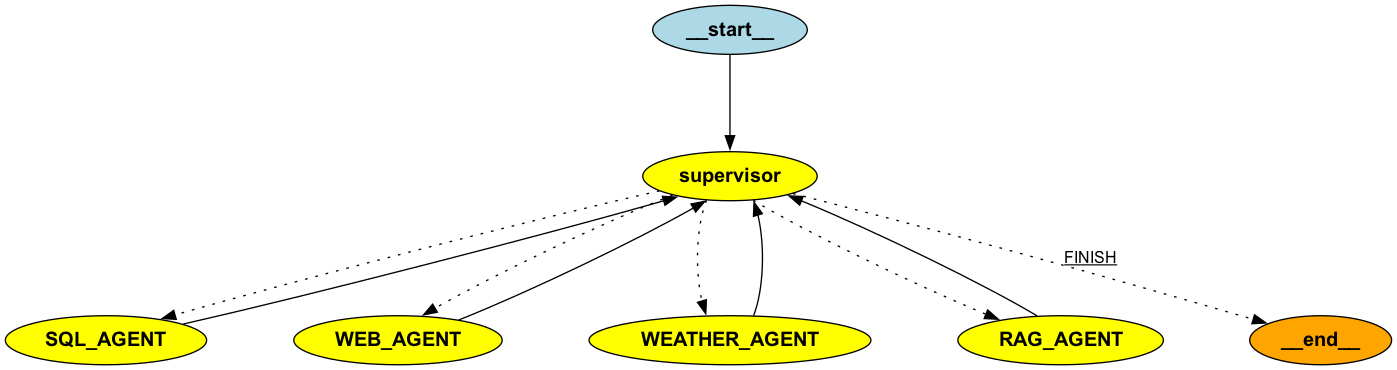

In [10]:
display(Image(app.get_graph().draw_png()))

In [ ]:
question = "What is the weather in New York?"
# question = "List all albums by the artist 'AC/DC'"
# question = "In which year did RCB win the IPL?"
# question = "What are some of the disadvantages of being a generalist?"


output = app.invoke({"question": question}, config={"recurssion_limit": 5})

------ SUPERVISOR NODE ------
Response from supervisor: {'next_action': 'RAG_AGENT'}
Next action determined by supervisor: RAG_AGENT
------ RAG NODE ------


> Entering new AgentExecutor chain...
Being a generalist can have several disadvantages, and I need to gather more specific information on this topic. I will use the RAGTool to find relevant data on the disadvantages of being a generalist.

Action: RAGTool
Action Input: "disadvantages of being a generalist"

Observation: ['Conversely, generalists can be perceived as lacking depth, making it difficult to establish authority or credibility in technical conversations. Their broad focus may prevent them from reaching peak performance in any single domain, which can be a disadvantage in competitive environments that reward deep expertise.\n\nIV. Sectoral Perspectives\nThe preference for specialists or generalists often varies by industry:\n\nHealthcare relies heavily on both. Specialists such as cardiologists or oncologists are essenti

In [134]:
from pprint import pprint

pprint(output["response"])

('Some disadvantages of being a generalist include the perception of lacking '
 'depth, difficulty in establishing authority or credibility in technical '
 'conversations, and the inability to reach peak performance in any single '
 'domain, especially in competitive environments that reward specialized '
 'expertise.')


In [137]:
# print(output["response"])